# Hamiltonian simulation with Gray code encoding - QASM version

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import pickle

from scipy.linalg import expm

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli

from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()


import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *

## Time evolution of the deuteron system

Consider the $N=4$ deuteron system. We have two Hamiltonians obtained from the Gray code and Jordan-Wigner encodings. Starting from an arbitrary quantum state, we can compute the state after the system evolves for time $t$ analytically as
$$
 |\psi(t)\rangle = e^{-iHt} |\psi(0)\rangle
$$

Let's suppose that $|\psi(0)\rangle$ is the uniform superposition of basis states for each system. For the Gray code, we have
$$
|\psi(0)\rangle = \frac{1}{2} \left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right)
$$
while for Jordan-Wigner, we are concerned with a subset of the basis states of a 4-qubit system:
$$
|\psi(0)\rangle = \frac{1}{2} \left( |0001\rangle + |0010\rangle + |0100\rangle + |1000\rangle \right)
$$

In [2]:
# Perform unitary evolution 
def unitary_evolution(ham, t):
    return expm(-1j * ham * t)

# Basis states for the two systems
states_gc = ['00', '10', '11', '01']
states_jw = ['1000', '0100', '0010', '0001']

colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Some simulation parameters; for better 'resolution', increase the number of timesteps 
timesteps = 1000
start_time = 0
end_time = 2
time_range = np.linspace(start_time, end_time, timesteps)

## QASM Simulation

In [3]:
# Arbitrary simulation time
T = 1

# Range of Trotter steps to use
min_trotter_steps = 1
max_trotter_steps = 100

backend = Aer.get_backend('qasm_simulator')

In [4]:
H = hamiltonian_matrix(Nmax=4,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_gc = GrayCodeHamiltonian(H,qiskit_order=False)
# H_gc = DenseEncodingHamiltonian(N_states=4)

# Get the matrix in "qiskit order"
# gc_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in H_gc.pauli_coeffs.items()])
gc_ham_rep = H_gc.matrix

uniform_superposition_gc = 0.5 * np.array([[1], [1], [1], [1]])

wavefunction = unitary_evolution(gc_ham_rep, t=T) @ uniform_superposition_gc
true_probabilities = (wavefunction * np.conj(wavefunction)).flatten().real

true_results_gc = {'00' : true_probabilities[0],
                   '10' : true_probabilities[1],
                   '11' : true_probabilities[3],
                   '01' : true_probabilities[2]
                  }

In [5]:
exact_wavefunction_gc = unitary_evolution(gc_ham_rep, t=T) @ uniform_superposition_gc

In [6]:
exact_wavefunction_gc * np.conj(exact_wavefunction_gc)

array([[0.54658009+0.j],
       [0.25      +0.j],
       [0.19470555+0.j],
       [0.00871437+0.j]])

In [7]:
true_results_gc

{'00': 0.5465800850008364,
 '10': 0.24999999999999956,
 '11': 0.008714366534098846,
 '01': 0.1947055484650645}

This code loops over the different numbers of Trotter steps and performs the evolution by running the circuit using the statevector simulator.

In [8]:
my_pauli = H_gc.weighted_pauli

results_dict_gc = {x : np.zeros(max_trotter_steps) for x in states_gc}

for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps+1)):
    # Boilerplate code from tutorial
    q = QuantumRegister(H_gc.N_qubits)
    c = ClassicalRegister(H_gc.N_qubits)
    
    circuit = QuantumCircuit(q, c)
    
    circuit.h(q)
    
    circuit += my_pauli.evolve(
        None, evo_time=T, num_time_slices=n_trotter_steps,
        quantum_registers=q,
        expansion_mode='trotter'
    )
    
    circuit.measure(q, c)

    job = execute(circuit, backend, shots=10000)
    
    results = job.result().get_counts(circuit)

    for state in results_dict_gc.keys():
        if state[::-1] in results.keys():
            results_dict_gc[state[::-1]][n_trotter_steps-1] = results[state]/10000

100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


In [9]:
exact_wavefunction_gc

array([[-0.17353329+0.71865589j],
       [ 0.5       +0.j        ],
       [-0.4276642 -0.10866869j],
       [-0.08625443-0.0357007j ]])

In [10]:
print(f"True state probabilities:")
for state in states_gc:
    print(f"{state}: {true_results_gc[state].real}")
print()
print(f"State probabilities at {max_trotter_steps} Trotter steps:")
for state in states_gc:
    print(f"{state}: {results_dict_gc[state][-1]}")

True state probabilities:
00: 0.5465800850008364
10: 0.24999999999999956
11: 0.008714366534098846
01: 0.1947055484650645

State probabilities at 100 Trotter steps:
00: 0.5681
10: 0.2508
11: 0.0064
01: 0.1747


Text(0.5, 1.0, '4 states, 2 qubits (Gray code); evolution time T = 1, Trotter')

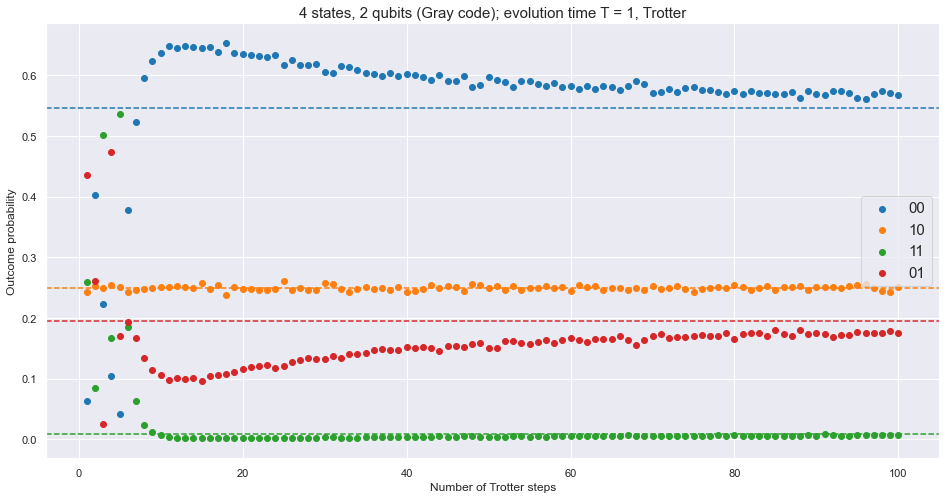

In [11]:
colour_idx = 0

for state in states_gc:
    plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=results_dict_gc[state], label=state, color=colours[colour_idx])
    plt.axhline(y=true_results_gc[state], color=colours[colour_idx], linestyle='dashed')
    colour_idx += 1
plt.xlabel("Number of Trotter steps")
plt.ylabel("Outcome probability")
plt.legend(fontsize=15)
plt.title(f"4 states, 2 qubits (Gray code); evolution time T = {T}, Trotter", fontsize=15)
#plt.savefig("gc-trotter-probs.pdf")

Now we'll do the same thing for Jordan-Wigner. We'll prepare the uniform superposition here by running the variational ansatz with the set of parameters that will produce it.

In [12]:
H = hamiltonian_matrix(Nmax=6,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
jw = JordanWignerHamiltonian(H,qiskit_order=False)

jw_ham_rep = reduce(lambda x, y: x + y, [p[1] * get_pauli_matrix(p[0]) for p in jw.pauli_coeffs.items()])

uniform_jw = 0.5 * np.array([[0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0]]).reshape((16, 1))

exact_wavefunction_jw = unitary_evolution(jw_ham_rep, t=T) @ uniform_jw

true_probabilities = (exact_wavefunction_jw * np.conj(exact_wavefunction_jw)).flatten()

true_results_jw = {'1000' : true_probabilities[1],
                   '0100' : true_probabilities[2],
                   '0010' : true_probabilities[4],
                   '0001' : true_probabilities[8]}

In [13]:
# H_jw = SparseEncodingHamiltonian(N_states=4, qiskit_order=True)
H = hamiltonian_matrix(Nmax=6,hw=7.0,J=1,interaction_filename="toy_hamiltonian") 
H_jw = JordanWignerHamiltonian(H,qiskit_order=True)

# weighted_paulis = [(v, Pauli.from_label(k)) for (k, v) in list(H_jw.pauli_coeffs.items())]
# my_pauli = WeightedPauliOperator(weighted_paulis)
my_pauli = H_jw.weighted_pauli

results_dict_jw = {x : np.zeros(max_trotter_steps) for x in states_jw}

# To prepare the uniform superposition, run the sparse variational ansatz with the following parameters
θ_1 = 2 * np.pi / 3
θ_2 = 2 * np.arccos(1/np.sqrt(3)) 
θ_3 = 2 * np.arccos(1/(np.sqrt(3) * np.sin(θ_2 / 2)))
params = [θ_1, θ_2, θ_3]

for n_trotter_steps in tqdm(range(min_trotter_steps, max_trotter_steps+1)):
    # Construct uniform superposition over spherical coordinates
    q = QuantumRegister(H_jw.N_qubits)
    c = ClassicalRegister(H_jw.N_qubits)
    
    circuit = QuantumCircuit(q, c)
    circuit.x(q[0])
    circuit.ry(θ_1, q[1])
    circuit.cx(q[1], q[0])
    circuit.cry(θ_2, q[1], q[2])
    circuit.cx(q[2], q[1])
    circuit.cry(θ_3, q[2], q[3])
    circuit.cx(q[3], q[2])
    
    circuit += my_pauli.evolve(
        None, evo_time=T, num_time_slices=n_trotter_steps,
        quantum_registers=q,
        expansion_mode='trotter'
    )
    
    circuit.measure(q, c)

    job = execute(circuit, backend, shots=10000)
    results = job.result().get_counts(circuit)
    
    for state in results_dict_jw.keys():
        if state[::-1] in results.keys():
            results_dict_jw[state[::-1]][n_trotter_steps-1] = results[state]/10000

100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


In [14]:
print(f"True state probabilities:")
for state in states_jw:
    print(f"{state}: {true_results_jw[state].real}")
print()
print(f"State probabilities at {max_trotter_steps} Trotter steps:")
for state in states_jw:
    print(f"{state}: {results_dict_jw[state][-1]}")

True state probabilities:
1000: 0.11822167070985506
0100: 0.1866178665300514
0010: 0.05027030387285183
0001: 0.6448901588872447

State probabilities at 100 Trotter steps:
1000: 0.6575
0100: 0.0422
0010: 0.161
0001: 0.1393


Text(0.5, 1.0, '4 states, 4 qubits (Jordan-Wigner); evolution time T = 2, Trotter')

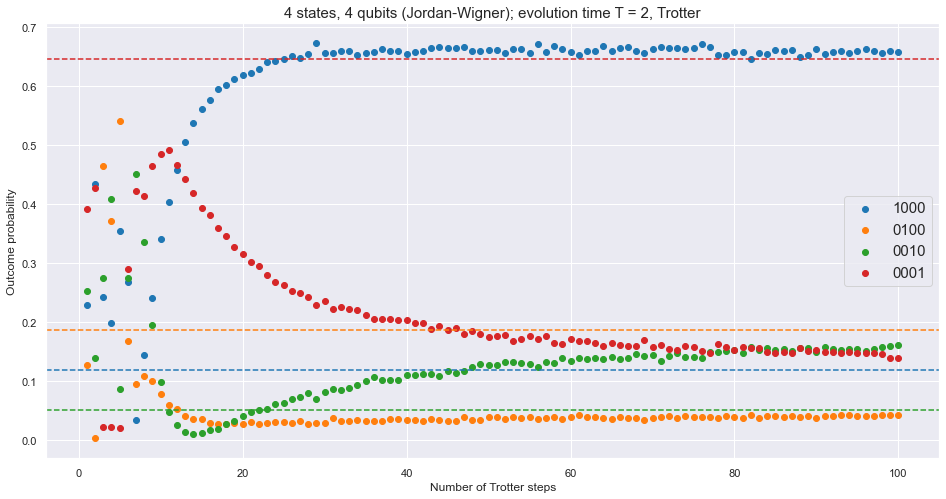

In [15]:
colour_idx = 0

for state in states_jw:
    plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=results_dict_jw[state], label=state, color=colours[colour_idx])
    plt.axhline(y=true_results_jw[state], color=colours[colour_idx], linestyle='dashed')
    colour_idx += 1
    
plt.xlabel("Number of Trotter steps")
plt.ylabel("Outcome probability")
plt.legend(fontsize=15)
plt.title("4 states, 4 qubits (Jordan-Wigner); evolution time T = 2, Trotter", fontsize=15)
#plt.savefig("jw-trotter-probs.pdf")

Text(0.5, 1.0, 'N=4 encoding comparison for Hamiltonian evolution time t = 1, QASM 10000 shots')

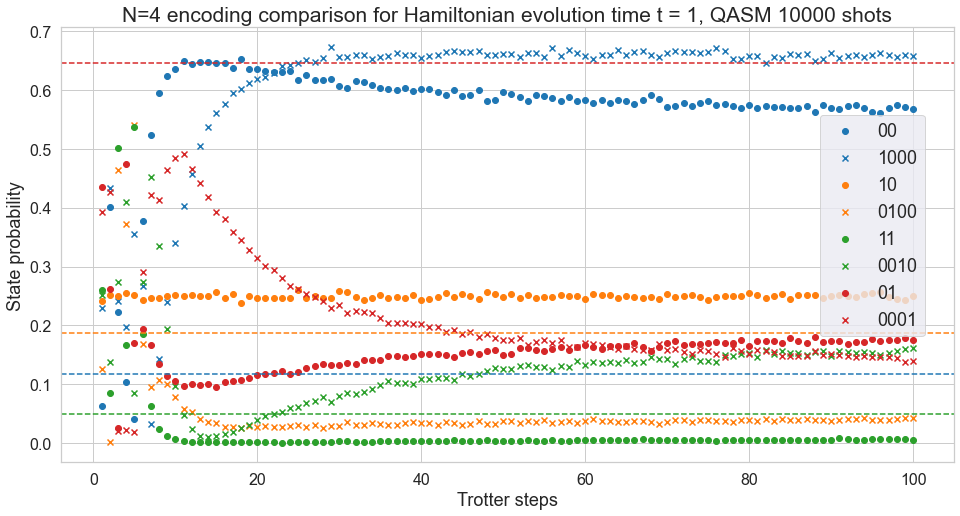

In [16]:
colour_idx = 0

with sns.axes_style("whitegrid"):
    for state_gc, state_jw in zip(states_gc, states_jw):
        plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=results_dict_gc[state_gc], label=state_gc, color=colours[colour_idx])
        plt.scatter(x=range(min_trotter_steps, max_trotter_steps+1), y=results_dict_jw[state_jw], label=state_jw, color=colours[colour_idx], marker='x')
        plt.axhline(y=true_results_jw[state_jw], color=colours[colour_idx], linestyle='dashed')
        colour_idx += 1
    
plt.xlabel("Trotter steps", fontsize=18)
plt.ylabel("State probability", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18, loc=(0.85, 0.29))
plt.title(f"N=4 encoding comparison for Hamiltonian evolution time t = {T}, QASM 10000 shots", fontsize=21)
# plt.savefig("paper-figures/trotter-probs-comparison.pdf")